In [65]:
!pip install gensim

In [66]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re

In [67]:
twitter_data = pd.read_csv('../data/clean_processed_tweet_data.csv')

In [68]:
twitter_data.shape

(16321, 16)

### Removing null raws

In [69]:
twitter_data.dropna()

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place


In [70]:
len(twitter_data)

16321

In [71]:
class PrepareData:
  def __init__(self,df):
    self.df=df
    
  def preprocess_data(self):
    tweets_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
    tweets_df['original_text']=tweets_df['original_text'].astype(str)
    tweets_df['original_text'] = tweets_df['original_text'].apply(lambda x: x.lower())
    tweets_df['original_text']= tweets_df['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
    
    #Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['original_text']]
    word_list = [sent.split() for sent in sentence_list]

    #Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list)
    corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]



    
    return word_list, word_to_id, corpus_1

In [72]:
PrepareData_obj=PrepareData(twitter_data)
word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

In [73]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [74]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('we', 0.020143272),
   ('be', 0.018363971),
   ('have', 0.017749583),
   ('out', 0.016125446),
   ('all', 0.015970517),
   ('will', 0.014745396),
   ('has', 0.013477435),
   ('what', 0.012209217),
   ('more', 0.010394601),
   ('how', 0.009317043)]),
 (1,
  [('nan', 0.34540665),
   ('our', 0.018508697),
   ('an', 0.011724095),
   ('his', 0.011709251),
   ('do', 0.008253877),
   ('why', 0.0077321655),
   ('congress', 0.0067706145),
   ('government', 0.005313495),
   ('or', 0.005155609),
   ('says', 0.005084264)]),
 (2,
  [('the', 0.08996939),
   ('to', 0.054572947),
   ('of', 0.047788296),
   ('a', 0.03994882),
   ('in', 0.037376195),
   ('is', 0.032193836),
   ('and', 0.031662207),
   ('for', 0.029475868),
   ('you', 0.017149167),
   ('this', 0.01428022)]),
 (3,
  [('amp', 0.028707698),
   ('president', 0.012553566),
   ('us', 0.012460349),
   ('pnpkakampimo', 0.011511913),
   ('weserveandprotect', 0.011191247),
   ('sri', 0.010848861),
   ('facebook', 0.010479901),
   ('teampn

In [75]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -9.105613125373583

 Ldamodel Coherence Score/Accuracy on Tweets:  0.4737094524355194


In [76]:
!pip install pyLDAvis 

In [77]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.318565  0.002051       1        1  40.440112
0     -0.079266 -0.227119       2        1  17.527205
4     -0.076064  0.048606       3        1  16.146654
3     -0.078046  0.010317       4        1  13.101380
1     -0.085189  0.166146       5        1  12.784649, topic_info=      Term         Freq        Total Category  logprob  loglift
250    nan  6509.000000  6509.000000  Default  30.0000  30.0000
15     the  5363.000000  5363.000000  Default  29.0000  29.0000
34      to  3253.000000  3253.000000  Default  28.0000  28.0000
8       of  2848.000000  2848.000000  Default  27.0000  27.0000
1        a  2381.000000  2381.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
737    air    41.481806    42.304208   Topic5  -6.1186   2.0373
201    gas    40.275177    41.083630   Topic5  -6.1481   2.0371
503     a…    36.838947    37.621589   Topic5  -6.2373   2.0359
2384  such    50.106548    51.180344   Topic5  -5.9297   2.0357
607   same    36.847722    37.640563   Topic5  -6.2371   2.0356

[197 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1478      3  0.993735     1
1480      3  0.989825     2
719       3  0.990672  2022
1481      3  0.987651     4
1         1  0.999700     a
...     ...       ...   ...
36        1  0.994844   you
36        2  0.004867   you
473       1  0.995931  your
37        5  0.984912     👇
1708      3  0.992936     🚀

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

In [78]:
cleanTweet = twitter_data[['original_text','polarity']]

In [79]:
def sentiment_catagory (p):
  if p > 0:
    return 'positive'
  elif p < 0:
    return 'negative'
  else:
    return 'neutral'

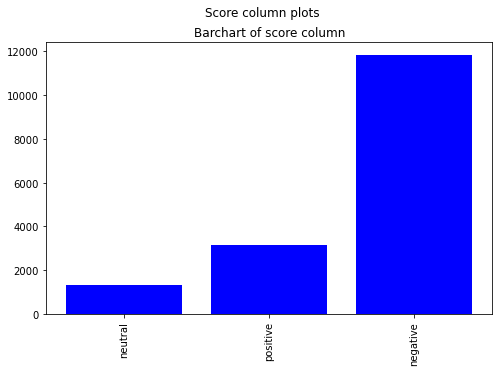

In [80]:
score = pd.Series([sentiment_catagory(row_val) for row_val in cleanTweet['polarity']])
cleanTweet = pd.concat([cleanTweet, score.rename("score")], axis=1)

# Visualize The  score  column using barchart

# Create a figure for 2 subplots (1 row, 2 columns)
labels = ['neutral', 'positive', 'negative']
positive = len(cleanTweet[cleanTweet['score'] == "positive"])
negative = len(cleanTweet[cleanTweet['score'] == "negative"])
neutral = len(cleanTweet[cleanTweet['score'] == "neutral"])
fig, ax = plt.subplots(1, 1, figsize = (8,5))

# Create a bar plot of score column
ax.bar(x=labels, height=[negative, positive, neutral], color='blue')
ax.set_title('Barchart of score column')
ax.set_xticklabels(labels, rotation=90)

# Add a title to the Figure
fig.suptitle('Score column plots')

# Show the figure
fig.show()

In [81]:
cleanTweet = cleanTweet.drop(cleanTweet[cleanTweet.score == 'neutral'].index)
scoremap = pd.Series([1 if row_val == 'positive' else 0 for row_val in cleanTweet['score']])
cleanTweet['scoremap'] = scoremap

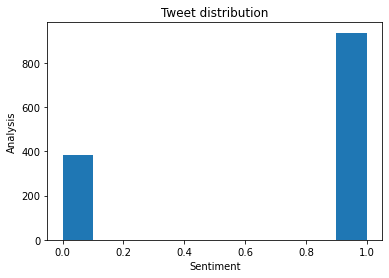

In [82]:
#Data Exploration

fig=plt.figure()
ax = fig.add_subplot(1,1,1)

#Variable
ax.hist(cleanTweet['scoremap'],bins = 10)

#Labels and Tit
plt.title('Tweet distribution')
plt.xlabel('Sentiment')
plt.ylabel('Analysis')
plt.show()